In [73]:
import random
import numpy as np
from ete3 import Tree, TreeNode

# -------------------------------
# 1-1. Yule tree
# -------------------------------
def simulate_yule_tree(n):
    """
    Yule pure-birth process tree with n leaves
    """
    root = TreeNode()
    leaves = [root]
    while len(leaves) < n:
        leaf = random.choice(leaves)
        leaves.remove(leaf)
        c1, c2 = TreeNode(), TreeNode()
        leaf.add_child(c1)
        leaf.add_child(c2)
        leaves.extend([c1, c2])
    return root


# -------------------------------
# 1-2. Birth-Death tree
# -------------------------------
def simulate_bd_tree(n, lam=1.0, mu=0.0, max_attempts=1000):
    """
    Birth-Death process tree with n leaves
    lam: birth rate
    mu: death rate
    """
    for _ in range(max_attempts):
        root = TreeNode()
        leaves = [root]

        while leaves and len(leaves) < n:
            leaf = random.choice(leaves)
            if random.random() < mu / (lam + mu):  # death event
                leaves.remove(leaf)
                if not leaves:
                    break
            else:  # birth event
                leaves.remove(leaf)
                c1, c2 = TreeNode(), TreeNode()
                leaf.add_child(c1)
                leaf.add_child(c2)
                leaves.extend([c1, c2])

        if len([x for x in root.iter_leaves()]) == n:
            return root

    raise ValueError("Failed to generate BD tree")


# -------------------------------
# 1-3. Kingman’s coalescent tree
# -------------------------------
def simulate_kingman_coalescent(n):
    """
    Kingman coalescent tree with n leaves
    """
    leaves = [TreeNode(name=f"L{i}") for i in range(n)]
    while len(leaves) > 1:
        a, b = random.sample(leaves, 2)
        parent = TreeNode()
        parent.add_child(a)
        parent.add_child(b)
        leaves.remove(a)
        leaves.remove(b)
        leaves.append(parent)
    return Tree(leaves[0].write(format=1), format=1)


# -------------------------------
# 1-4. Beta-splitting tree
# -------------------------------
def simulate_beta_splitting_tree(n, beta=0.0):
    leaves = list(range(n))
    
    def split_leaves(leaves, internal_id=[0]):
        if len(leaves) == 1:
            return Tree(name=str(leaves[0]))
        n_leaves = len(leaves)
        a, b = max(beta+1, 1e-6), max(beta+1, 1e-6)
        ratio = np.random.beta(a, b)
        lsize = max(1, min(n_leaves-1, int(round(ratio*n_leaves))))
        left_leaves = random.sample(leaves, lsize)
        right_leaves = [l for l in leaves if l not in left_leaves]
        left_tree = split_leaves(left_leaves, internal_id)
        right_tree = split_leaves(right_leaves, internal_id)
        root = Tree(name=f"N{internal_id[0]}")
        internal_id[0] += 1
        root.add_child(left_tree)
        root.add_child(right_tree)
        return root
    
    return split_leaves(leaves)

In [74]:
from math import gcd

# ===============================
# 2. Root subtree 비율 추출
# ===============================
def count_leaves(tree):
    """트리의 leaf 수를 계산"""
    if tree.is_leaf():
        return 1
    return sum(count_leaves(c) for c in tree.get_children())

def root_subtree_ratio(tree):
    """
    루트 바로 아래에서 두 자식 subtree의 leaf 수 비율 계산
    ratio는 항상 작은쪽:큰쪽 형태
    """
    children = tree.get_children()
    if len(children) != 2:
        return []  # binary tree가 아닌 경우 무시

    l = count_leaves(children[0])
    r = count_leaves(children[1])

    # gcd로 약분
    g = gcd(l, r)
    l_simple, r_simple = l // g, r // g

    # 항상 작은 수를 앞에
    if l_simple > r_simple:
        l_simple, r_simple = r_simple, l_simple

    return [(l_simple, r_simple)]

In [ ]:
import random
import numpy as np
from ete3 import Tree

# ===============================
# 3. Simulation
# ===============================
def run_simulation(n_list, models, params, num_samples=500):
    """
    n_list: leaf 수 리스트 (예: [8,16])
    models: 사용할 모델 이름 리스트 (예: ["Yule","BD","Kingman","BetaSplitting"])
    params: 모델별 파라미터 딕셔너리
    num_samples: 각 설정별 시뮬레이션 횟수
    """
    results = {model:{} for model in models}

    for n in n_list:
        for model in models:
            param_list = params.get(model)
            results[model][n] = []

            for param in param_list:
                for _ in range(num_samples):
                    # 트리 생성
                    if model == "Yule":
                        t = simulate_yule_tree(n)
                    elif model == "BD":
                        t = simulate_bd_tree(n, lam=param['lam'], mu=param['mu'])
                    elif model == "Kingman":
                        t = simulate_kingman_coalescent(n)
                    elif model == "BetaSplitting":
                        t = simulate_beta_splitting_tree(n, beta=param)
                    else:
                        raise ValueError(f"Unknown model: {model}")

                    # subtree 비율 계산
                    ratios = root_subtree_ratio(t)
                    results[model][n].extend(ratios)

    return results

In [76]:
def plot_subtree_ratios_param_separate(results, n_list, models, params, top_k=10):
    from collections import Counter
    from math import gcd
    import matplotlib.pyplot as plt

    for model in models:
        for n in n_list:
            param_list = params[model]
            for idx, param in enumerate(param_list):
                # run_simulation 구조: results[model][n]는 리스트 of ratios
                # param 별로 num_samples만큼 묶여있다고 가정하고 slice
                num_samples = 500  # run_simulation에서 사용한 값
                start = idx * num_samples
                end = start + num_samples
                ratios_raw = results[model][n][start:end]

                ratio_counter = Counter()
                for l,r in ratios_raw:
                    g = gcd(l,r)
                    l_simple, r_simple = l//g, r//g
                    if l_simple > r_simple:
                        l_simple, r_simple = r_simple, l_simple
                    label = f"{l_simple}:{r_simple}"
                    ratio_counter[label] += 1

                # 상위 top_k만 표시
                most_common = ratio_counter.most_common(top_k)
                if not most_common:
                    continue
                labels, values = zip(*most_common)

                plt.figure(figsize=(6,4))
                plt.bar(range(len(values)), values, color='skyblue')
                plt.xticks(range(len(values)), labels, rotation=45)
                plt.ylabel("Count")
                plt.title(f"{model}, n={n}, param={param}")
                plt.tight_layout()
                plt.show()

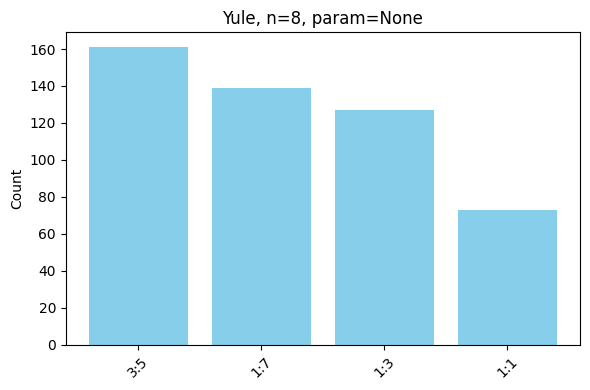

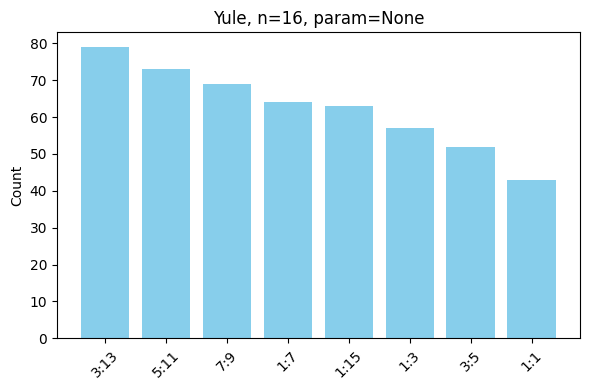

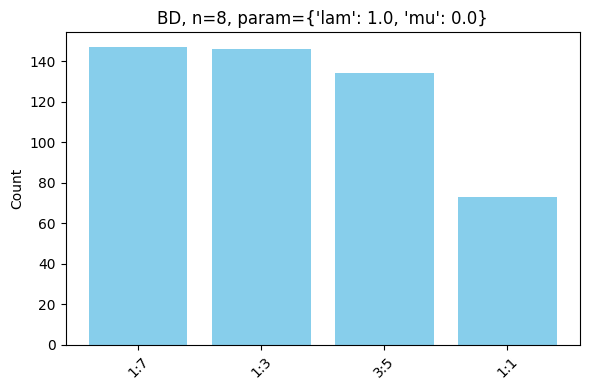

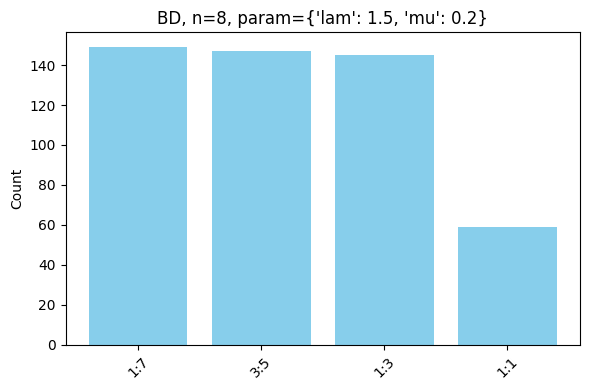

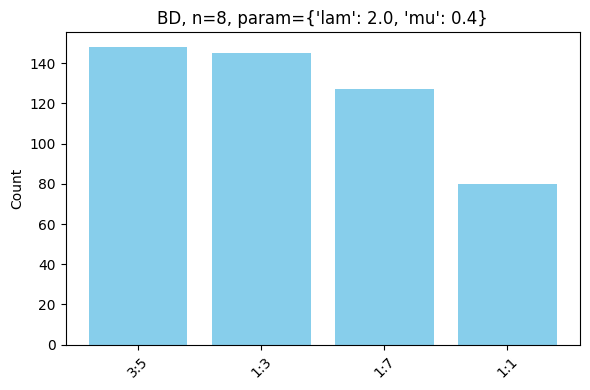

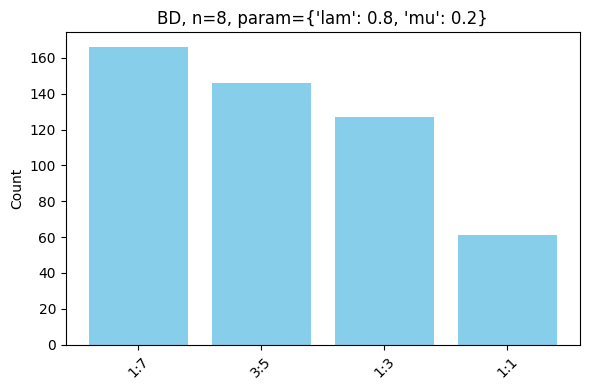

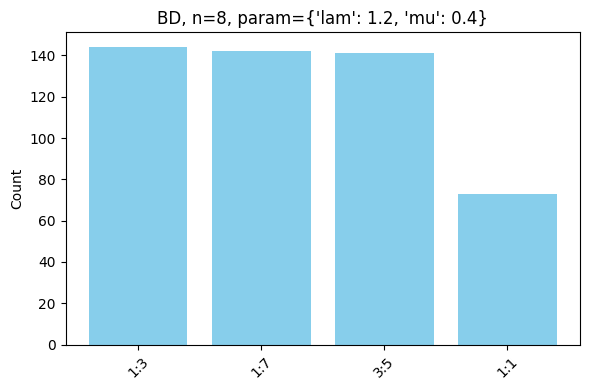

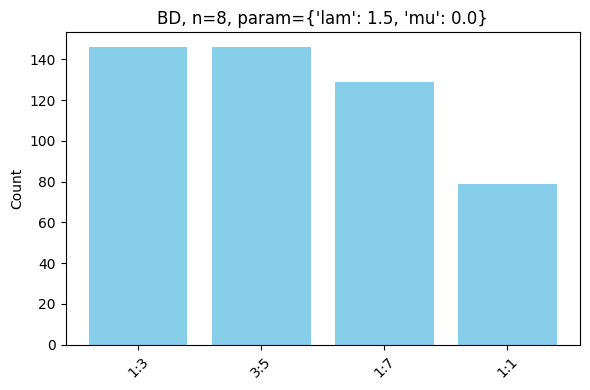

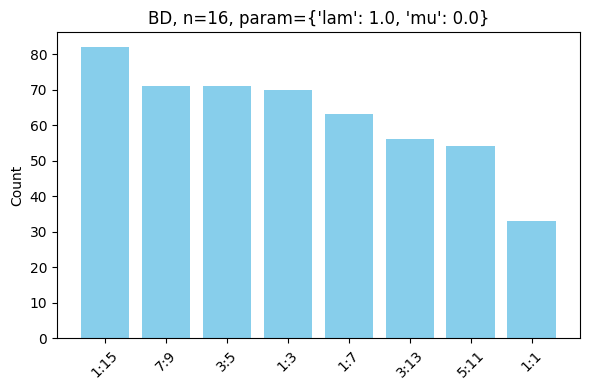

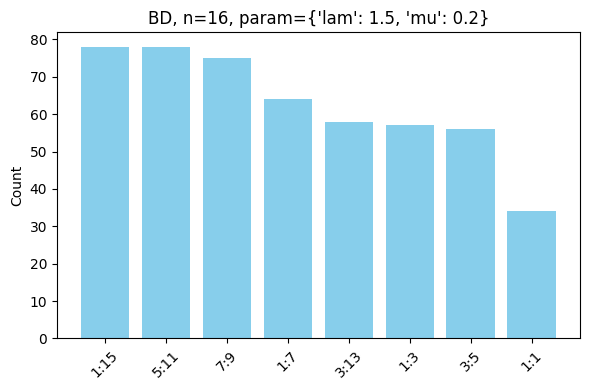

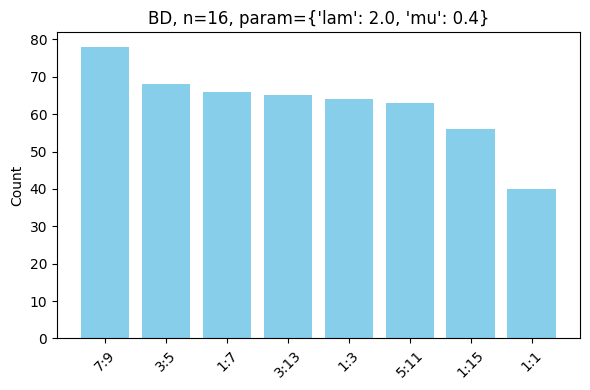

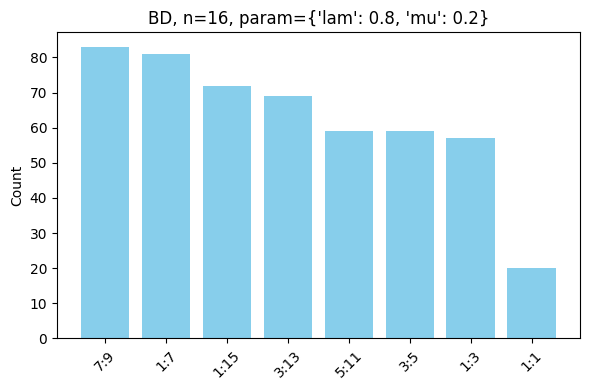

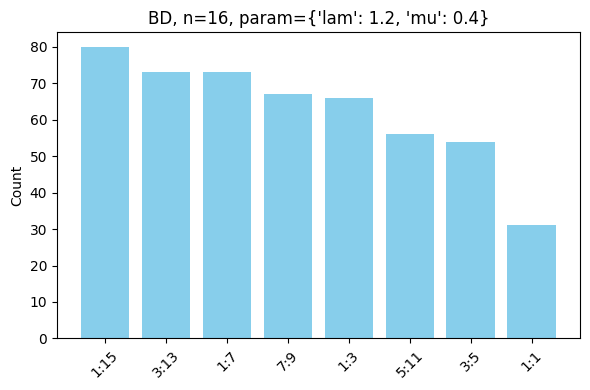

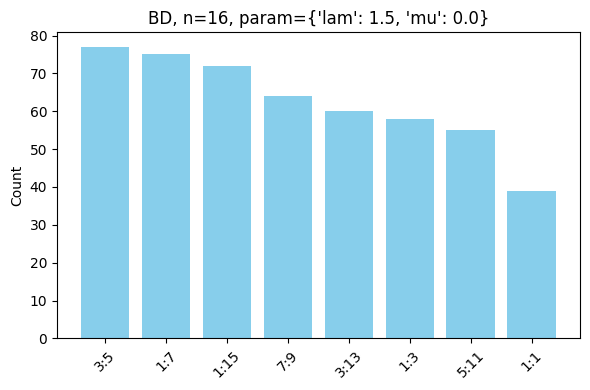

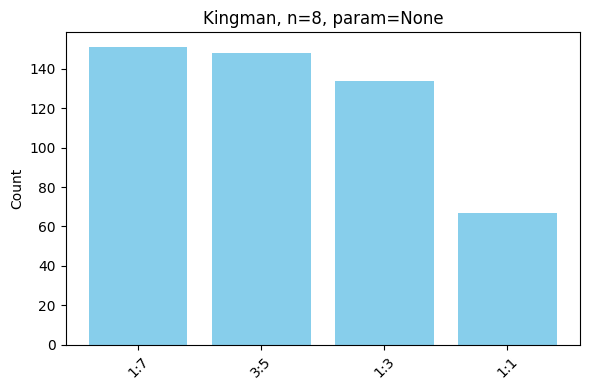

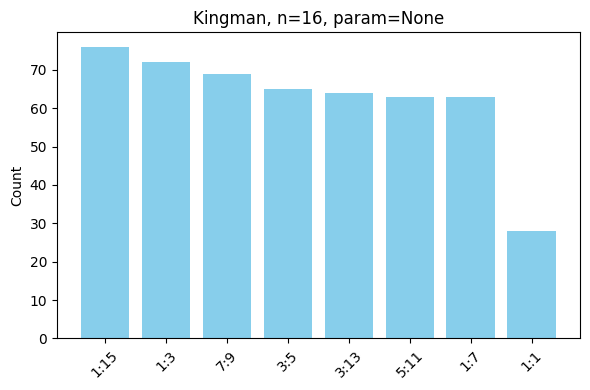

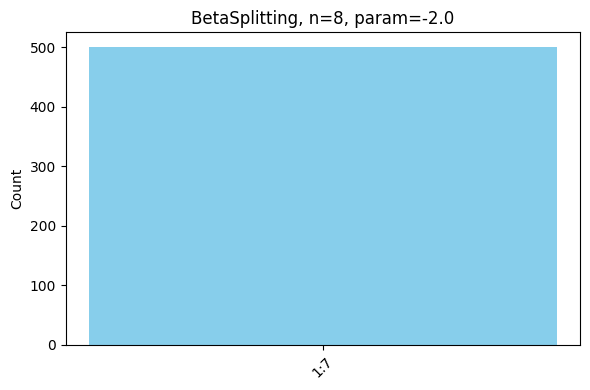

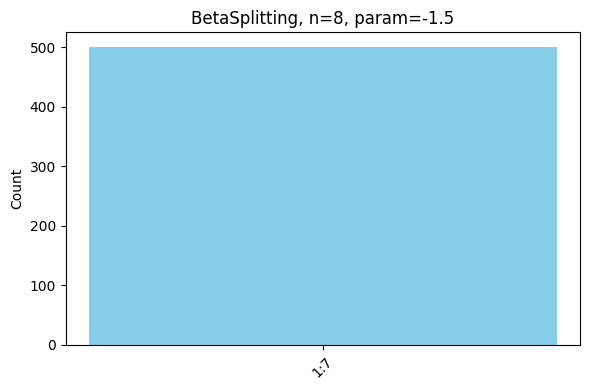

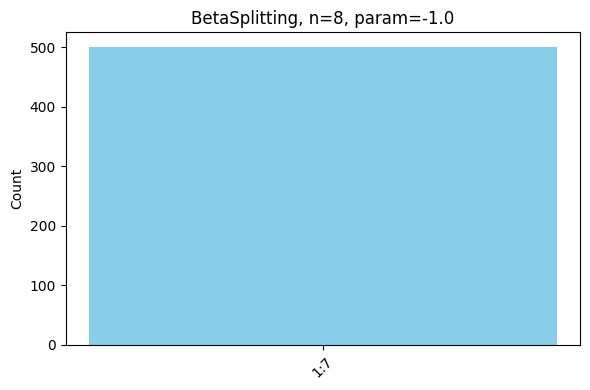

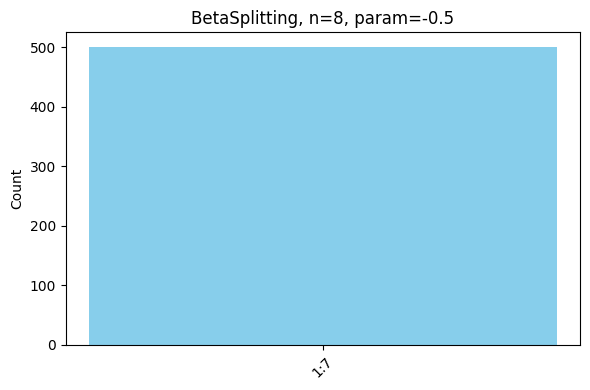

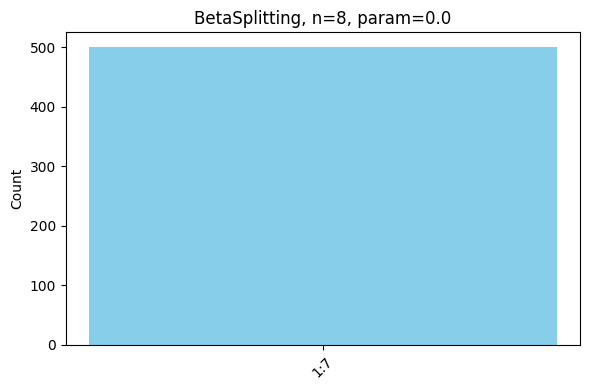

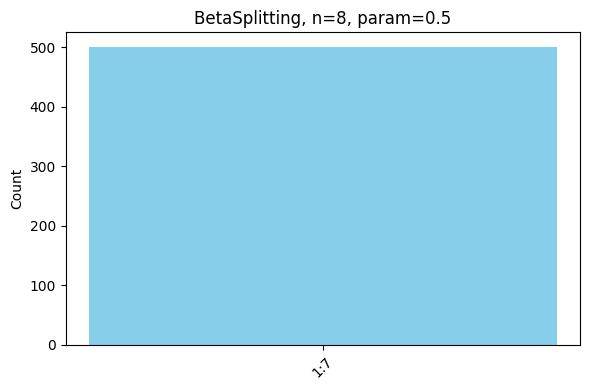

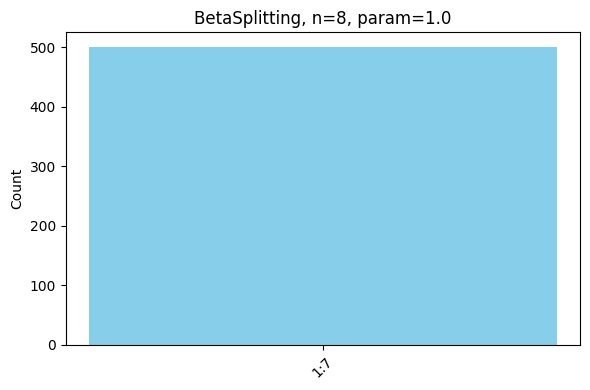

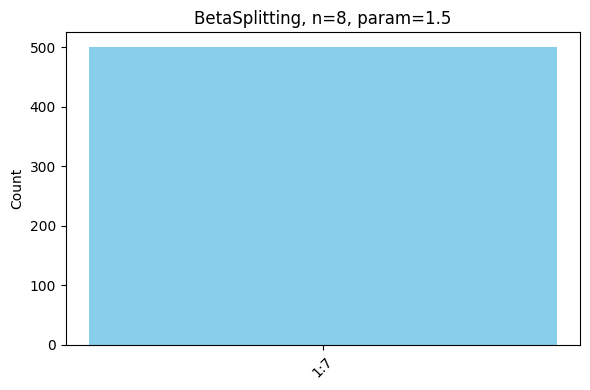

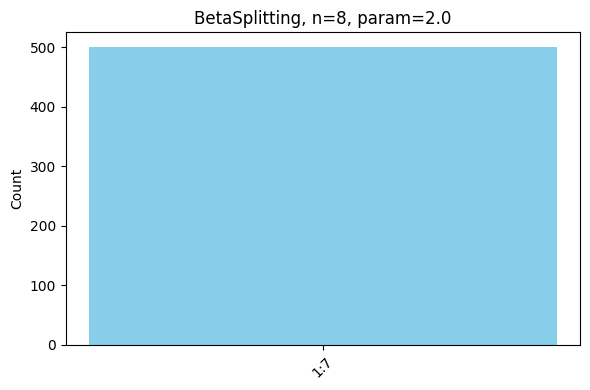

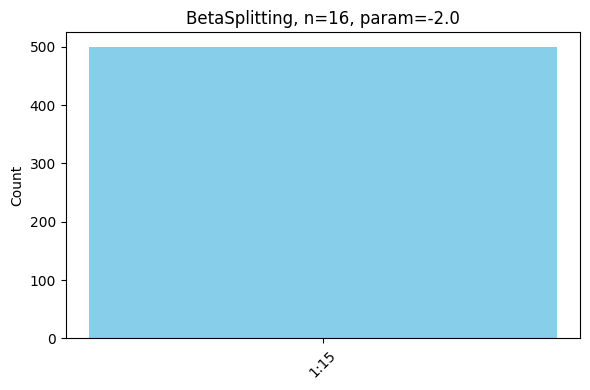

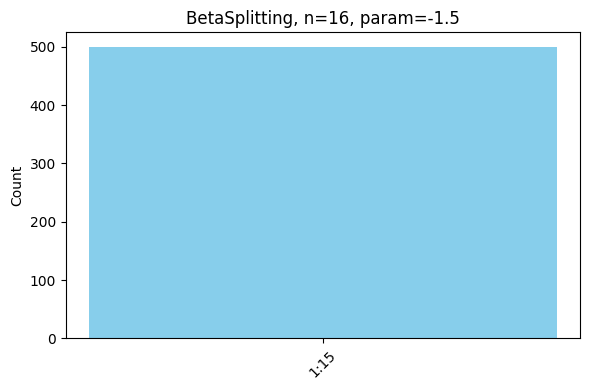

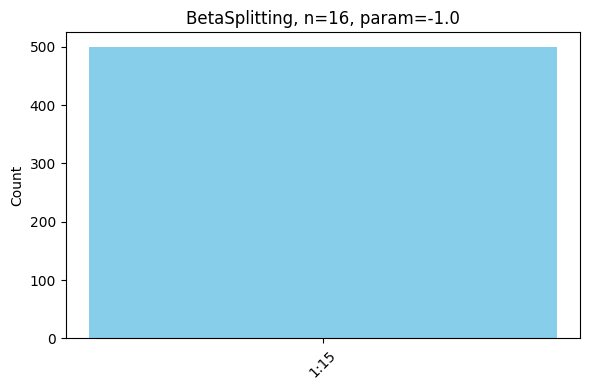

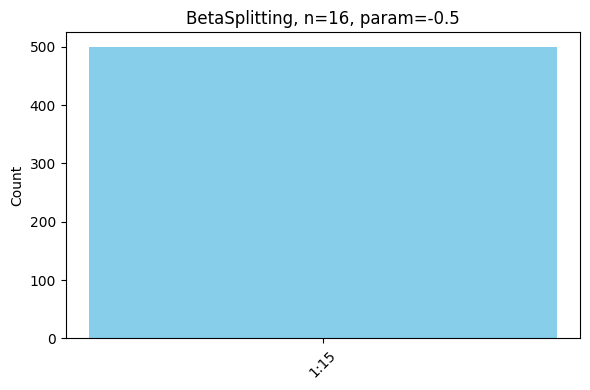

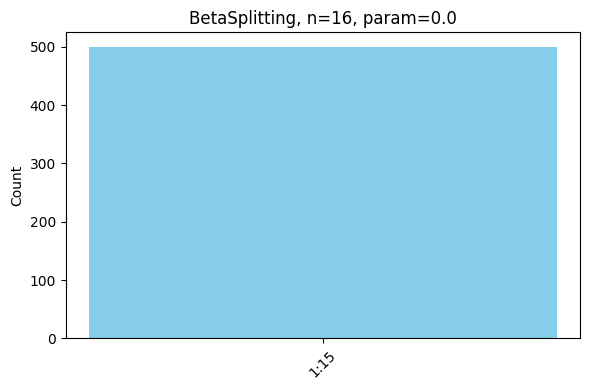

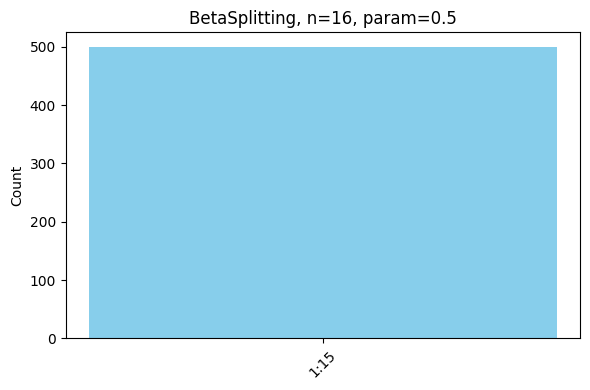

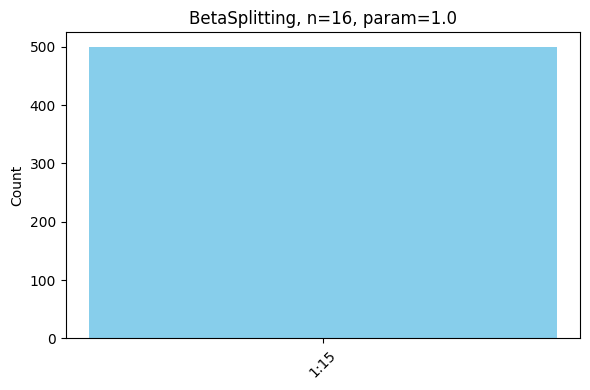

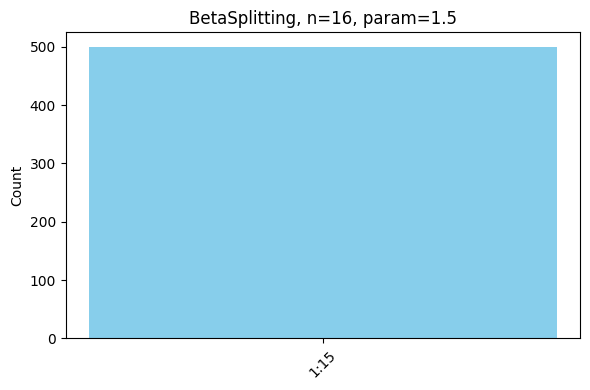

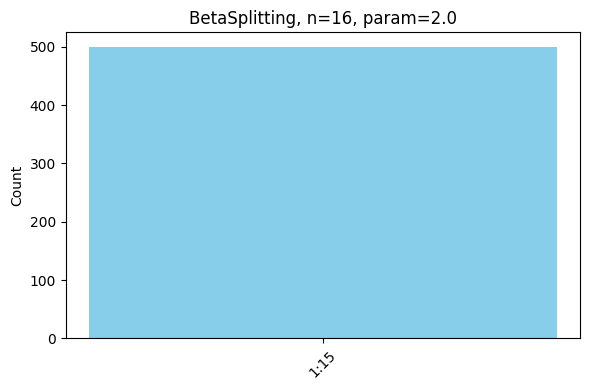

In [78]:
n_list = [8, 16]
models = ["Yule", "BD", "Kingman", "BetaSplitting"]

params = {
    "Yule": [None],
    "BD": [
        {'lam':1.0,'mu':0.0},
        {'lam':1.5,'mu':0.2},
        {'lam':2.0,'mu':0.4},
        {'lam':0.8,'mu':0.2},
        {'lam':1.2,'mu':0.4},
        {'lam':1.5,'mu':0.0}
    ],
    "Kingman": [None],
    "BetaSplitting": [-2.0,-1.5,-1.0,-0.5,0.0,0.5,1.0,1.5,2.0]
}

num_samples = 10000  # 샘플 개수
results = run_simulation(n_list, models, params, num_samples=num_samples)
plot_subtree_ratios_param_separate(results, n_list, models, params, top_k=10)

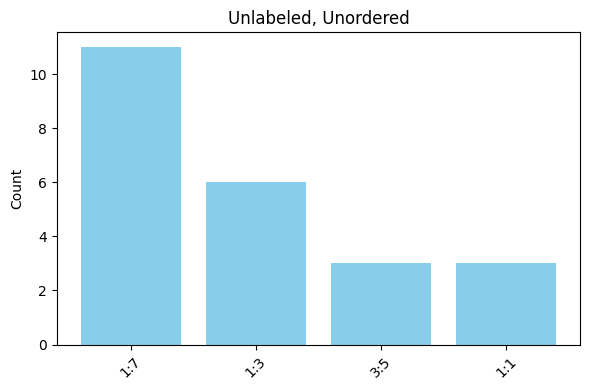

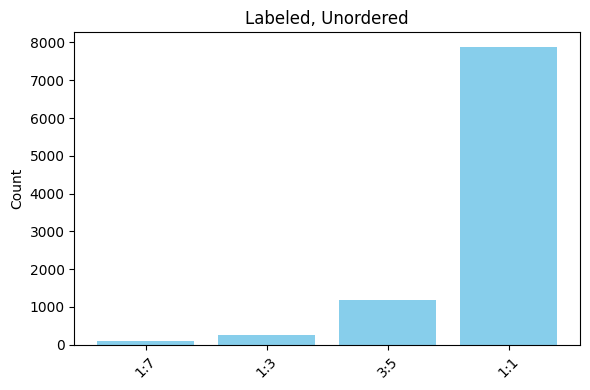

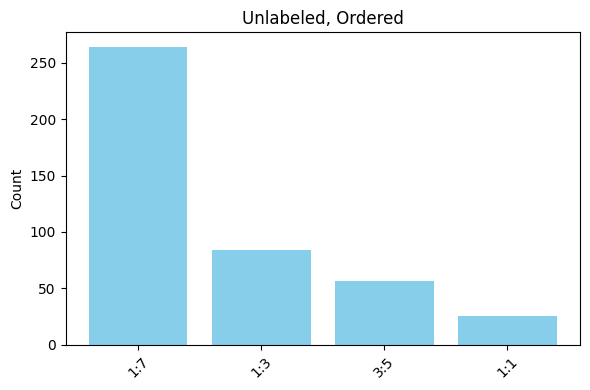

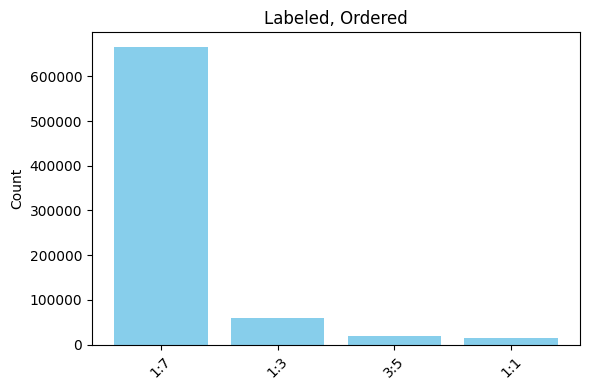

In [88]:
# 예시 데이터
results = {
    "Unlabeled, Unordered": {8: [(1,7),(2,6),(3,5),(4,4)]},
    "Labeled, Unordered": {8: [(1,7),(2,6),(3,5),(4,4)]},
    "Unlabeled, Ordered": {8: [(1,7),(2,6),(3,5),(4,4)]},
    "Labeled, Ordered": {8: [(1,7),(2,6),(3,5),(4,4)]},
}

counts = {
    "Unlabeled, Unordered": [11, 6, 3, 3],
    "Labeled, Unordered": [88, 252, 1176, 7875],
    "Unlabeled, Ordered": [264, 84, 56, 25],
    "Labeled, Ordered": [665280, 60480, 20160, 14400]
}

import matplotlib.pyplot as plt
from math import gcd

for ttype, vals in results.items():
    ratios = vals[8]
    ratio_counts = counts[ttype]

    # 최소비율로 변환
    labels = []
    for L,R in ratios:
        g = gcd(L,R)
        labels.append(f"{L//g}:{R//g}")

    plt.figure(figsize=(6,4))
    plt.bar(range(len(ratio_counts)), ratio_counts, color='skyblue')
    plt.xticks(range(len(ratio_counts)), labels, rotation=45)
    plt.ylabel("Count")
    plt.title(ttype)
    plt.tight_layout()
    plt.show()

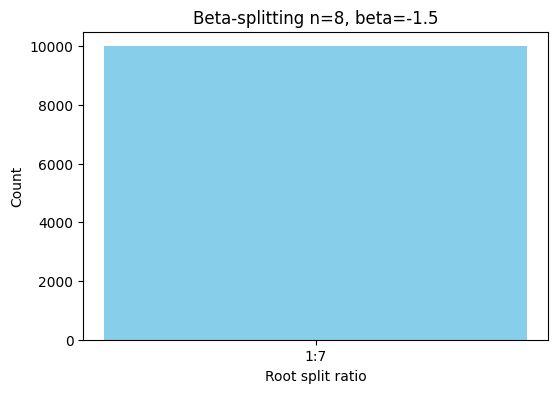

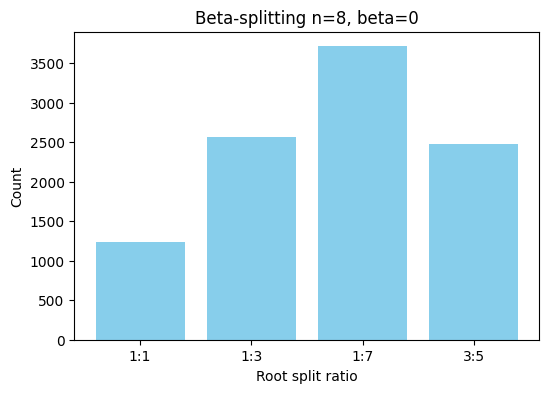

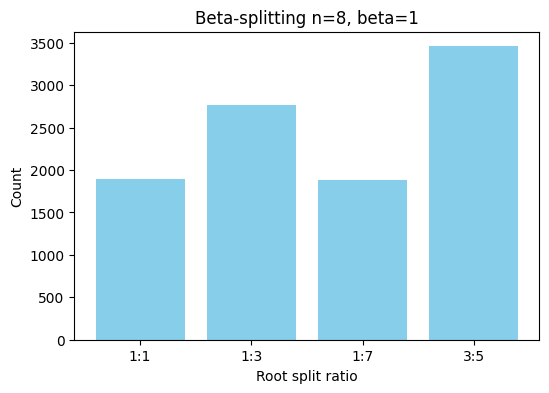

In [89]:
import random
from ete3 import Tree
from collections import Counter
import matplotlib.pyplot as plt
from math import gcd

# -------------------------------
# Beta-splitting tree 시뮬레이션 (n=8)
# -------------------------------
def simulate_beta_splitting_tree(n, beta=0.0):
    leaves = list(range(n))
    
    def split_leaves(leaves, internal_id=[0]):
        if len(leaves) == 1:
            return Tree(name=str(leaves[0]))
        n_leaves = len(leaves)
        a, b = max(beta+1, 1e-6), max(beta+1, 1e-6)
        ratio = random.betavariate(a, b)
        lsize = max(1, min(n_leaves-1, int(round(ratio*n_leaves))))
        left_leaves = random.sample(leaves, lsize)
        right_leaves = [l for l in leaves if l not in left_leaves]
        left_tree = split_leaves(left_leaves, internal_id)
        right_tree = split_leaves(right_leaves, internal_id)
        root = Tree(name=f"N{internal_id[0]}")
        internal_id[0] += 1
        root.add_child(left_tree)
        root.add_child(right_tree)
        return root
    
    return split_leaves(leaves)

# -------------------------------
# Root subtree ratio 계산
# -------------------------------
def count_leaves(tree):
    if tree.is_leaf():
        return 1
    return sum(count_leaves(c) for c in tree.children)

def root_subtree_ratio(tree):
    children = tree.children
    if len(children) != 2:
        return []
    l, r = count_leaves(children[0]), count_leaves(children[1])
    g = gcd(l,r)
    return [(l//g, r//g) if l<=r else (r//g, l//g)]

# -------------------------------
# 시뮬레이션 및 plotting
# -------------------------------
betas = [-1.5, 0, 1]
num_samples = 10000
n = 8

results = {}

for beta in betas:
    ratios_all = []
    for _ in range(num_samples):
        t = simulate_beta_splitting_tree(n, beta=beta)
        ratios = root_subtree_ratio(t)
        if ratios:
            ratios_all.extend(ratios)
    results[beta] = ratios_all

# plot
for beta, ratios_all in results.items():
    counter = Counter()
    for l,r in ratios_all:
        counter[f"{l}:{r}"] += 1
    labels, values = zip(*sorted(counter.items()))
    plt.figure(figsize=(6,4))
    plt.bar(labels, values, color='skyblue')
    plt.title(f"Beta-splitting n=8, beta={beta}")
    plt.xlabel("Root split ratio")
    plt.ylabel("Count")
    plt.show()

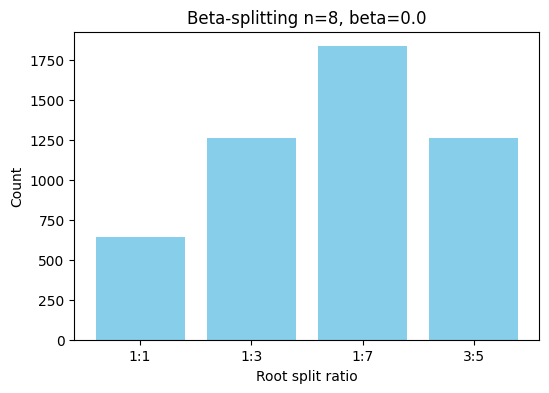

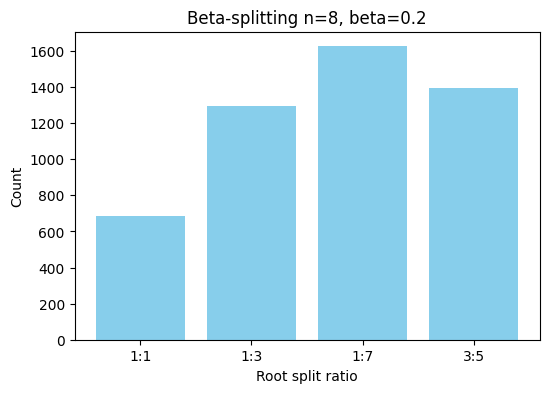

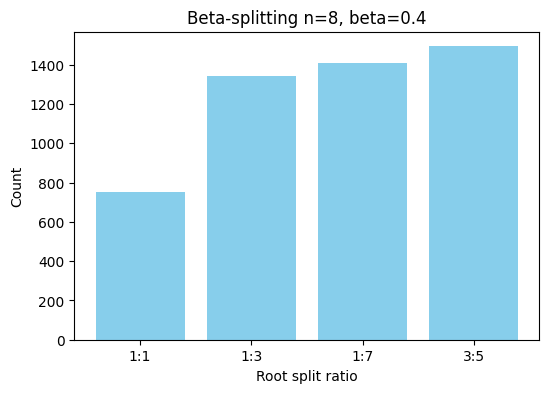

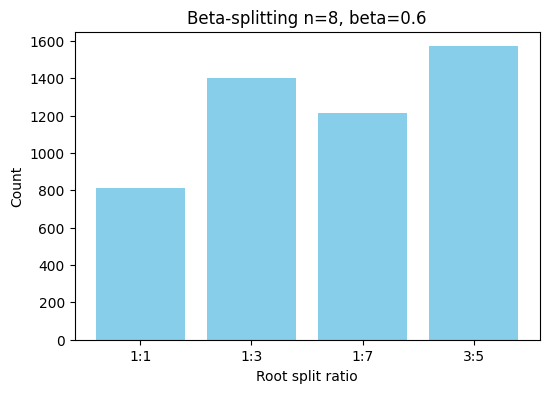

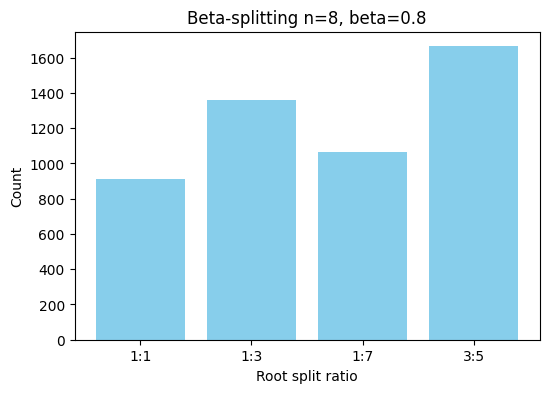

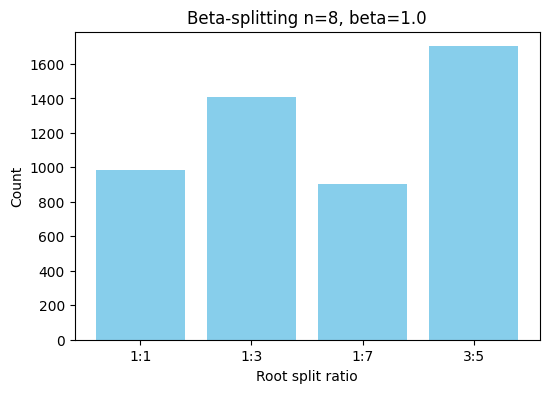

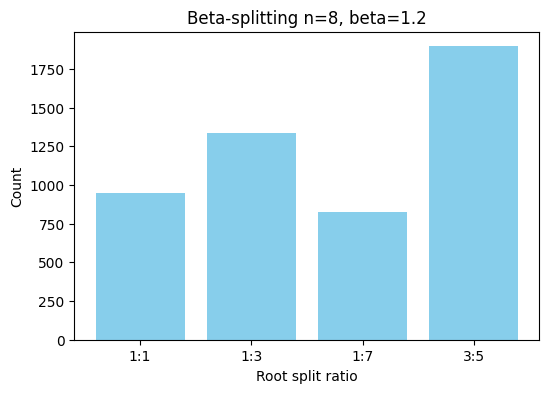

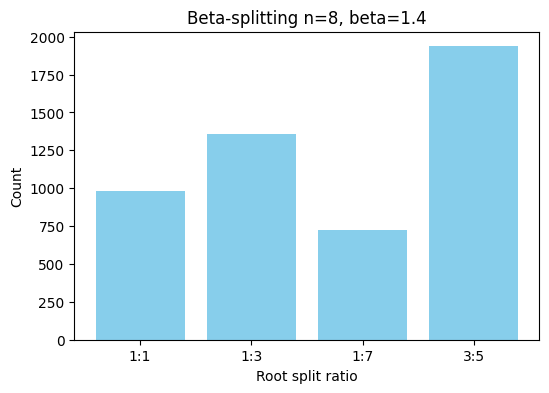

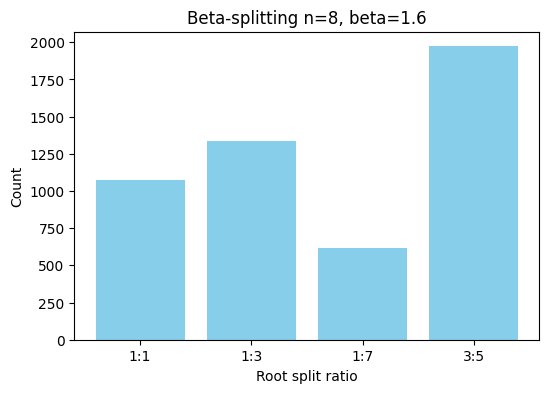

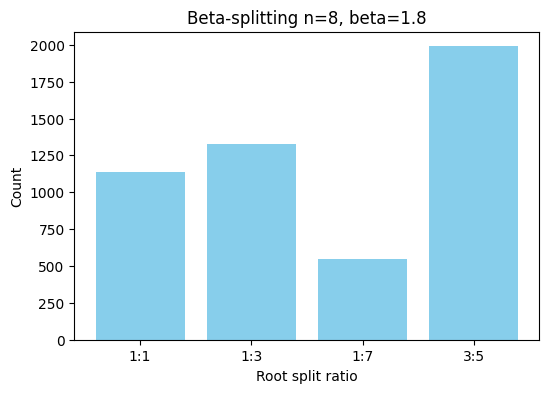

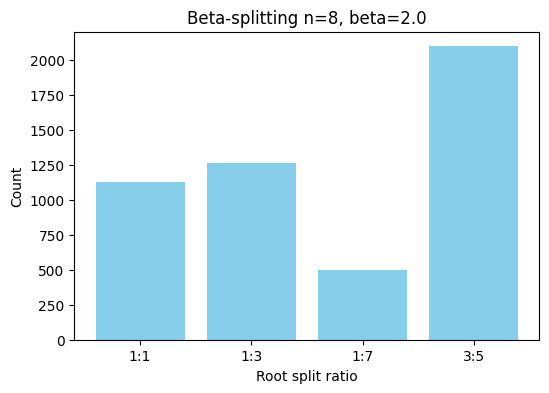

In [90]:
import random
from ete3 import Tree
from collections import Counter
import matplotlib.pyplot as plt
from math import gcd

# -------------------------------
# Beta-splitting tree 시뮬레이션
# -------------------------------
def simulate_beta_splitting_tree(n, beta=0.0):
    leaves = list(range(n))
    
    def split_leaves(leaves, internal_id=[0]):
        if len(leaves) == 1:
            return Tree(name=str(leaves[0]))
        n_leaves = len(leaves)
        a, b = max(beta+1, 1e-6), max(beta+1, 1e-6)
        ratio = random.betavariate(a, b)
        lsize = max(1, min(n_leaves-1, int(round(ratio*n_leaves))))
        left_leaves = random.sample(leaves, lsize)
        right_leaves = [l for l in leaves if l not in left_leaves]
        left_tree = split_leaves(left_leaves, internal_id)
        right_tree = split_leaves(right_leaves, internal_id)
        root = Tree(name=f"N{internal_id[0]}")
        internal_id[0] += 1
        root.add_child(left_tree)
        root.add_child(right_tree)
        return root
    
    return split_leaves(leaves)

# -------------------------------
# Root subtree ratio 계산
# -------------------------------
def count_leaves(tree):
    if tree.is_leaf():
        return 1
    return sum(count_leaves(c) for c in tree.children)

def root_subtree_ratio(tree):
    children = tree.children
    if len(children) != 2:
        return []
    l, r = count_leaves(children[0]), count_leaves(children[1])
    g = gcd(l,r)
    return [(l//g, r//g) if l<=r else (r//g, l//g)]

# -------------------------------
# 시뮬레이션
# -------------------------------
betas = [round(0 + 0.2*i, 1) for i in range(11)]
num_samples = 5000
n = 8

results = {}

for beta in betas:
    ratios_all = []
    for _ in range(num_samples):
        t = simulate_beta_splitting_tree(n, beta=beta)
        ratios = root_subtree_ratio(t)
        if ratios:
            ratios_all.extend(ratios)
    results[beta] = ratios_all

# -------------------------------
# Plotting
# -------------------------------
for beta, ratios_all in results.items():
    counter = Counter()
    for l,r in ratios_all:
        counter[f"{l}:{r}"] += 1
    labels, values = zip(*sorted(counter.items()))
    plt.figure(figsize=(6,4))
    plt.bar(labels, values, color='skyblue')
    plt.title(f"Beta-splitting n=8, beta={beta}")
    plt.xlabel("Root split ratio")
    plt.ylabel("Count")
    plt.show()

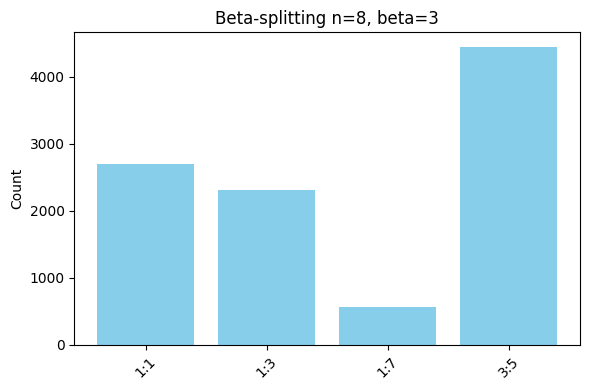

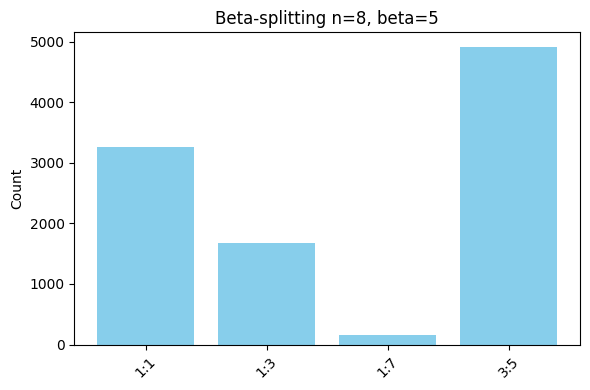

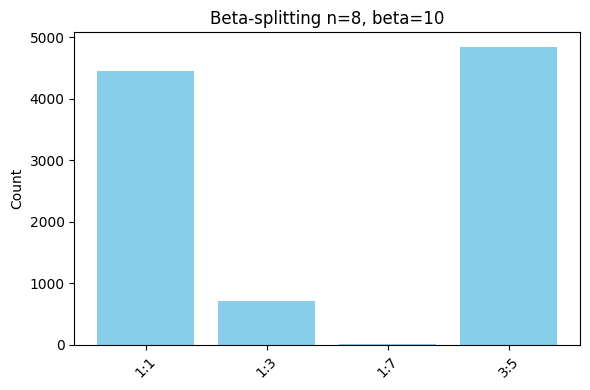

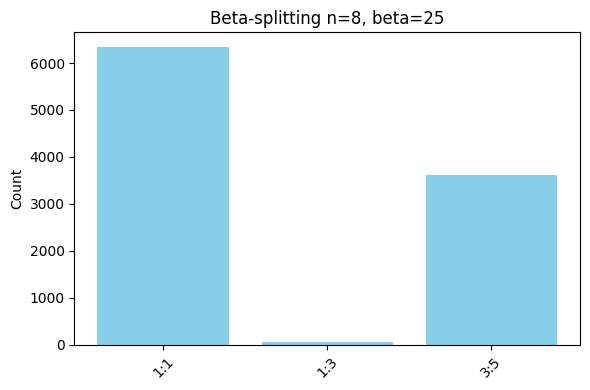

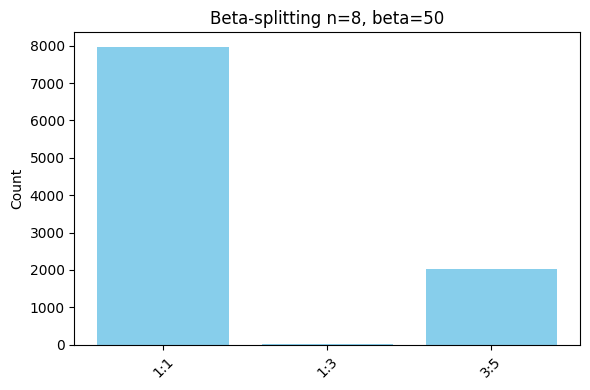

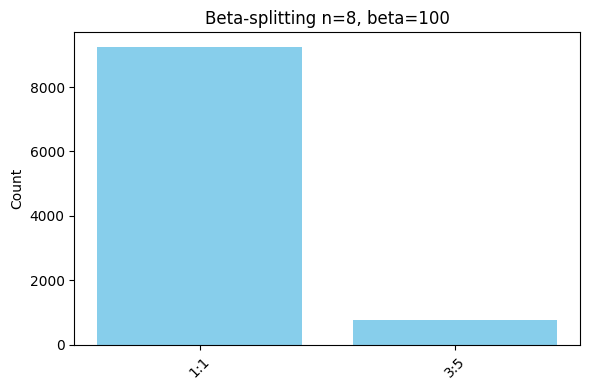

In [91]:
import numpy as np
import random
from ete3 import Tree
from collections import Counter
from math import gcd
import matplotlib.pyplot as plt

# -----------------------------
# Beta-splitting 트리 생성 (n=8)
def simulate_beta_splitting_tree(n, beta=0.0):
    leaves = list(range(n))
    
    def split_leaves(leaves, internal_id=[0]):
        if len(leaves) == 1:
            return Tree(name=str(leaves[0]))
        n_leaves = len(leaves)
        a, b = max(beta+1, 1e-6), max(beta+1, 1e-6)
        ratio = np.random.beta(a, b)
        lsize = max(1, min(n_leaves-1, int(round(ratio*n_leaves))))
        left_leaves = random.sample(leaves, lsize)
        right_leaves = [l for l in leaves if l not in left_leaves]
        left_tree = split_leaves(left_leaves, internal_id)
        right_tree = split_leaves(right_leaves, internal_id)
        root = Tree(name=f"N{internal_id[0]}")
        internal_id[0] += 1
        root.add_child(left_tree)
        root.add_child(right_tree)
        return root
    
    return split_leaves(leaves)

# -----------------------------
# 루트 split 비율 계산
def root_subtree_ratio(tree):
    children = tree.get_children()
    if len(children) != 2:
        return None
    l, r = len(children[0].get_leaves()), len(children[1].get_leaves())
    g = gcd(l, r)
    return (l//g, r//g) if l <= r else (r//g, l//g)

# -----------------------------
# 시뮬레이션 및 plot
n = 8
betas = [3, 5, 10, 25, 50, 100]
num_samples = 10000

for beta in betas:
    ratios = []
    for _ in range(num_samples):
        t = simulate_beta_splitting_tree(n, beta=beta)
        r = root_subtree_ratio(t)
        if r:
            ratios.append(r)
    
    counter = Counter(ratios)
    labels, values = zip(*sorted(counter.items()))
    labels_str = [f"{l}:{r}" for l,r in labels]
    
    plt.figure(figsize=(6,4))
    plt.bar(range(len(values)), values, color='skyblue')
    plt.xticks(range(len(values)), labels_str, rotation=45)
    plt.ylabel("Count")
    plt.title(f"Beta-splitting n={n}, beta={beta}")
    plt.tight_layout()
    plt.show()

In [98]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import random
from ete3 import Tree
from math import gcd

# ----------------------------
# Beta-splitting tree
def simulate_beta_splitting_tree(n, beta=0.0):
    leaves = list(range(n))
    def split_leaves(leaves, internal_id=[0]):
        if len(leaves) == 1:
            return Tree(name=str(leaves[0]))
        n_leaves = len(leaves)
        a = max(beta+1, 1e-6)
        b = max(beta+1, 1e-6)
        ratio = np.random.beta(a, b)
        lsize = max(1, min(n_leaves-1, int(round(ratio*n_leaves))))
        left_leaves = random.sample(leaves, lsize)
        right_leaves = [l for l in leaves if l not in left_leaves]
        left_tree = split_leaves(left_leaves, internal_id)
        right_tree = split_leaves(right_leaves, internal_id)
        root = Tree(name=f"N{internal_id[0]}")
        internal_id[0] += 1
        root.add_child(left_tree)
        root.add_child(right_tree)
        return root
    return split_leaves(leaves)

# ----------------------------
# Root subtree ratio 계산
def root_subtree_ratio(tree):
    children = tree.get_children()
    if len(children) != 2:
        return None
    l = count_leaves(children[0])
    r = count_leaves(children[1])
    g = gcd(l,r)
    l_simple, r_simple = l//g, r//g
    # 항상 작은쪽:큰쪽
    if l_simple > r_simple:
        l_simple, r_simple = r_simple, l_simple
    return f"{l_simple}:{r_simple}"

def count_leaves(tree):
    if tree.is_leaf():
        return 1
    return sum(count_leaves(c) for c in tree.get_children())

# ----------------------------
# 비율 계산 & 애니메이션 (barplot)
def create_beta_gif_ratio(n, betas, num_samples=200, filename="beta_ratio_bar.gif"):
    # 가능한 split ratio
    ratios_possible = [f"{i}:{n-i}" for i in range(1, n//2+1)]
    ratios_per_beta = []

    for beta in betas:
        counts = {r:0 for r in ratios_possible}
        for _ in range(num_samples):
            t = simulate_beta_splitting_tree(n, beta=beta)
            ratio = root_subtree_ratio(t)
            if ratio in counts:
                counts[ratio] += 1
        # 전체 tree 중 비율
        ratios_per_beta.append([counts[r]/num_samples for r in ratios_possible])

    # 애니메이션
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_ylim(0,1)
    bars = ax.bar(ratios_possible, ratios_per_beta[0], color='skyblue')
    ax.set_ylabel("Proportion")
    ax.set_xlabel("Root subtree ratio")
    
    def update(frame):
        beta = betas[frame]
        counts = ratios_per_beta[frame]
        for bar, h in zip(bars, counts):
            bar.set_height(h)
        ax.set_title(f"Beta-splitting n={n}, beta={beta}")
        return bars

    ani = FuncAnimation(fig, update, frames=len(betas), blit=False)
    ani.save(filename, writer=PillowWriter(fps=2))
    plt.close()

# ----------------------------
# 실행
betas = [-100, -50, -25, -10, -5, -2, -1, -0.5, 0, 0.5, 1, 2, 5, 10, 25, 50, 100]

create_beta_gif_ratio(8, betas, num_samples=200, filename="beta_n8_ratio.gif")
create_beta_gif_ratio(16, betas, num_samples=200, filename="beta_n16_ratio.gif")

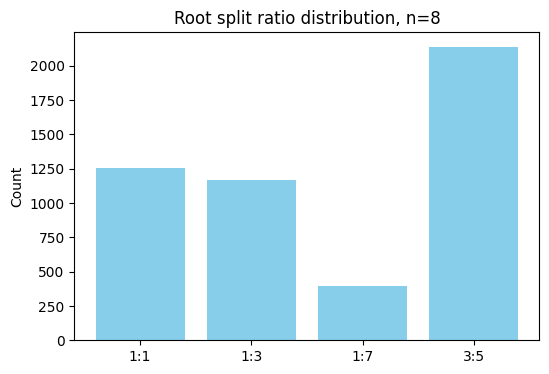

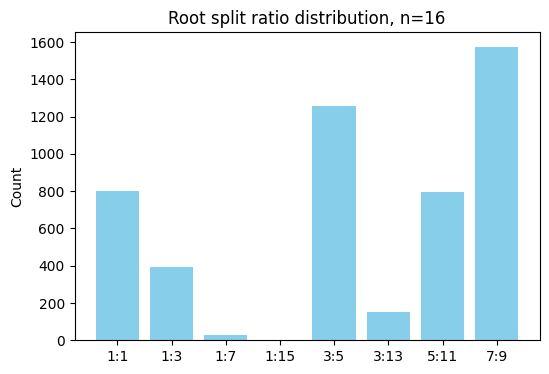

In [99]:
import random
import numpy as np
from ete3 import Tree
import matplotlib.pyplot as plt
from math import gcd
from collections import Counter

# -----------------------------
# Beta-splitting 트리 생성
# -----------------------------
def simulate_beta_splitting_tree(n, beta=0.0):
    leaves = list(range(n))
    
    def split_leaves(leaves, internal_id=[0]):
        if len(leaves) == 1:
            return Tree(name=str(leaves[0]))
        n_leaves = len(leaves)
        a, b = max(beta+1, 1e-6), max(beta+1, 1e-6)
        ratio = np.random.beta(a, b)
        lsize = max(1, min(n_leaves-1, int(round(ratio*n_leaves))))
        left_leaves = random.sample(leaves, lsize)
        right_leaves = [l for l in leaves if l not in left_leaves]
        left_tree = split_leaves(left_leaves, internal_id)
        right_tree = split_leaves(right_leaves, internal_id)
        root = Tree(name=f"N{internal_id[0]}")
        internal_id[0] += 1
        root.add_child(left_tree)
        root.add_child(right_tree)
        return root
    
    return split_leaves(leaves)

# -----------------------------
# 부분 트리 root ratio 계산
# -----------------------------
def root_subtree_ratio(tree, selected_leaves):
    """
    tree: ETE3 Tree
    selected_leaves: leaf 이름 리스트
    """
    # induced subtree
    subtree = tree.copy()
    # pruning leaves not in selected_leaves
    for leaf in subtree.get_leaves():
        if int(leaf.name) not in selected_leaves:
            leaf.delete()
    
    children = subtree.get_children()
    if len(children) != 2:
        return None
    l = len(children[0].get_leaves())
    r = len(children[1].get_leaves())
    g = gcd(l,r)
    return (l//g, r//g) if l<=r else (r//g, l//g)

# -----------------------------
# 시뮬레이션
# -----------------------------
def simulate_root_ratio(N_big=128, sample_n_list=[8,16], beta=0.0, num_samples=5000):
    # 큰 트리 생성
    big_tree = simulate_beta_splitting_tree(N_big, beta=beta)
    leaves_big = list(range(N_big))
    
    results = {n:[] for n in sample_n_list}
    
    for n in sample_n_list:
        for _ in range(num_samples):
            selected = random.sample(leaves_big, n)
            ratio = root_subtree_ratio(big_tree, selected)
            if ratio is not None:
                results[n].append(ratio)
    return results

# -----------------------------
# barplot 그리기
# -----------------------------
def plot_root_ratio(results, n_list):
    for n in n_list:
        counts = Counter(results[n])
        labels, values = zip(*sorted(counts.items()))
        plt.figure(figsize=(6,4))
        plt.bar([f"{l}:{r}" for l,r in labels], values, color='skyblue')
        plt.ylabel("Count")
        plt.title(f"Root split ratio distribution, n={n}")
        plt.show()

# -----------------------------
# 실행 예시
# -----------------------------
n_list = [8,16]
beta = 0.0  # 균등
results = simulate_root_ratio(N_big=128, sample_n_list=n_list, beta=beta, num_samples=5000)
plot_root_ratio(results, n_list)

In [141]:
import numpy as np
from ete3 import Tree
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from math import gcd

# ----------------------------
# Beta-splitting 트리 생성 (논문 방식, index 기준 split)
# ----------------------------
def simulate_beta_splitting_tree_uniform(n, beta):
    leaves = np.random.uniform(0, 1, n)

    def split(leaves_sub):
        if len(leaves_sub) == 1:
            return Tree(name=str(leaves_sub[0]))
        size = len(leaves_sub)

        # beta 분포 파라미터
        a = beta + 1
        b = beta + 1
        if a <= 0 or b <= 0:
            # 너무 극단적이면 작은 값으로 보정
            a = max(a, 1e-6)
            b = max(b, 1e-6)
        
        x = np.random.beta(a, b)
        left_leaves = [l for l in leaves_sub if l <= x]
        right_leaves = [l for l in leaves_sub if l > x]

        # 한쪽이 비어있으면 끝에서 한 개를 옮김
        if len(left_leaves) == 0:
            left_leaves.append(right_leaves.pop(0))  # 오른쪽 첫 번째를 왼쪽으로
        elif len(right_leaves) == 0:
            right_leaves.append(left_leaves.pop(-1))  # 왼쪽 마지막을 오른쪽으로

        left_tree = split(left_leaves)
        right_tree = split(right_leaves)
        root = Tree()
        root.add_child(left_tree)
        root.add_child(right_tree)
        return root

    return split(list(leaves))

# ----------------------------
# 루트 split ratio 계산
# ----------------------------
def root_subtree_ratio(tree):
    children = tree.get_children()
    if len(children) == 0:
        return None
    elif len(children) == 1:
        l = len(children[0].get_leaves())
        r = 0
    else:
        l = len(children[0].get_leaves())
        r = len(children[1].get_leaves())
    l_simple, r_simple = l, r
    if l_simple > r_simple:
        l_simple, r_simple = r_simple, l_simple
    return f"{l_simple}:{r_simple}"
# ----------------------------
# GIF 생성
# ----------------------------
def make_beta_gif(n, beta_values=None, num_samples=50, filename="beta.gif"):
    # beta_values가 None이면 기본 linspace 생성
    if beta_values is None:
        beta_values = np.linspace(-0.9, 2, 100)
    
    ratios = [f"{i}:{n-i}" for i in range(1, n//2+1)]
    images = []

    for beta in beta_values:
        ratio_counts = {r:0 for r in ratios}
        for _ in range(num_samples):
            t = simulate_beta_splitting_tree_uniform(n, beta)
            r = root_subtree_ratio(t)
            if r in ratio_counts:
                ratio_counts[r] += 1

        ratio_values = [ratio_counts[r]/num_samples for r in ratios]

        # bar plot
        plt.figure(figsize=(6,4))
        plt.bar(range(len(ratios)), ratio_values, color='skyblue')
        plt.xticks(range(len(ratios)), ratios, rotation=45)
        plt.ylim(0, max(ratio_values)*1.1)  # 최대값보다 10% 여유
        plt.ylabel("Proportion")
        plt.title(f"Beta-splitting n={n}, beta={beta:.2f}")
        plt.tight_layout()

        # 메모리에 저장
        buf = BytesIO()
        plt.savefig(buf, format='png')
        plt.close()
        buf.seek(0)
        images.append(Image.open(buf))

    # GIF 생성
    images[0].save(
        filename,
        save_all=True,
        append_images=images[1:],
        duration=100,  # 프레임 간격 (ms)
        loop=0
    )

# ----------------------------
# 실행 예시

beta_values = np.concatenate([
    np.linspace(-1+pow(10, -2), 1, 300),  # 0 근처 세밀하게
    np.linspace(1, 100, 100)          # 양수 쪽 넓은 범위
])
make_beta_gif(8, beta_values, num_samples=100, filename="beta_n8.gif")
make_beta_gif(16, beta_values, num_samples=100, filename="beta_n16.gif")